<a href="https://colab.research.google.com/github/EivisMat/gilusismokymasis/blob/main/2%20lab/1.1/cnn_vehicle_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required imports

In [1]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load in the dataset used. We're using this [Vehicle classification dataset (Kaggle)](https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification).

*Note: I've manually gone through the dataset and modified it a little bit to make it easier to work with. This includes renaming some of the images (mainly in the Cars subdirectory, as the original dataset seems to just skip certain values. As an example, it jumps from Cars (18) to Cars (21)) as well as throw out some images (like Plane (718).webp)*

In [2]:
base_url: str = "https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/1.1/Vehicles" # The github repo where the image dataset is held
# All class names (subdirectories) and how many images in each
class_names: dict = {"Auto Rickshaws" : 800,
                     "Bikes" : 800,
                     "Cars" : 790,
                     "Motorcycles" : 800,
                     "Planes" : 797,
                     "Ships" : 800,
                     "Trains" : 800}

# Initialize a list to hold all the image urls and one for their labels
image_urls: list = []
labels: list = []

# Basically, each subdirectory of every class has an 's' at the end (e.g. Auto Rickshaws)
# Whereas the individual image files do not. So we have to cut that 's' off ourselves.
# For example, the path would be base_url/Auto Rickshaws/Auto Rickshaw (1).jpg
# Additionally, we want to replace the space character " " with its hexadecimal
# representation %20. This gives us the final path:
# base_url/Auto%20Rickshaws/Auto%20Rickshaw%20(1).jpg
for class_name in class_names.keys():
  for i in range(class_names[class_name]):
    image_urls.append(f"{base_url}/{class_name}/{class_name[:-1]} ({i+1}).jpg".replace(" ", "%20"))
    labels.append(class_name[:-1])

print(len(image_urls))
print(image_urls[0], labels[0])

5587
https://raw.githubusercontent.com/EivisMat/gilusismokymasis/refs/heads/main/2%20lab/1.1/Vehicles/Auto%20Rickshaws/Auto%20Rickshaw%20(1).jpg Auto Rickshaw


In [3]:
# This is supremely stupid. The dataset has both .jpg and .png formats
# On top of that, the formats are also randomly capitalized
# So we end up with having .jpg, .JPG, .png, .PNG
# And thus this long chain of try-except is born.

def load_image_from_url(url: str):
  try:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((128, 128))
    return np.array(img)
  except Exception as e:
    try:
      response = requests.get(f"{url[:-3]}png")
      img = Image.open(BytesIO(response.content))
      img = img.resize((128, 128))
      return np.array(img)
    except Exception as e2:
      try:
        response = requests.get(f"{url[:-3]}JPG")
        img = Image.open(BytesIO(response.content))
        img = img.resize((128, 128))
        return np.array(img)
      except Exception as e3:
        try:
          response = requests.get(f"{url[:-3]}PNG")
          img = Image.open(BytesIO(response.content))
          img = img.resize((128, 128))
          return np.array(img)
        except Exception as e4:
          print(f"Error loading image from {url[:-3]}PNG: {e4}")
          return None

In [4]:
images: list = [load_image_from_url(url) for url in tqdm(image_urls)]

100%|██████████| 5587/5587 [18:23<00:00,  5.06it/s]


# Normalizing images

In [5]:
images = [i/255 for i in images]

# Filter images (some have 4 channels, some have 0)

In [6]:
filtered_images = []
filtered_labels = []

In [7]:
for i in range(len(images)):
  if images[i].shape == (128, 128, 3):
    filtered_images.append(images[i])
    filtered_labels.append(labels[i])

In [8]:
df = pd.DataFrame({
    "image": filtered_images,
    "label": filtered_labels
})

In [9]:
df = df[df["image"].notnull()]
x = np.stack(df["image"].values)  # Stack images into a numpy array
y = df["label"].factorize()[0]  # Convert categorical labels to integers

dataset = tf.data.Dataset.from_tensor_slices((x, y))

# Shuffle and batch the data
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(x)).batch(batch_size)

# Repeat dataset for training
dataset = dataset.repeat()

# Split into train, validation and test

In [10]:
# Split into training and validation datasets
train_size = int(0.8 * len(x))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

steps_per_epoch = train_size // batch_size  # Calculate steps per epoch
validation_steps = (len(x) - train_size) // batch_size  # Validation steps

# Create model

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7))

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,490,503 (9.50 MB)

 Trainable params: 2,490,503 (9.50 MB)

 Non-trainable params: 0 (0.00 B)

# Plot model

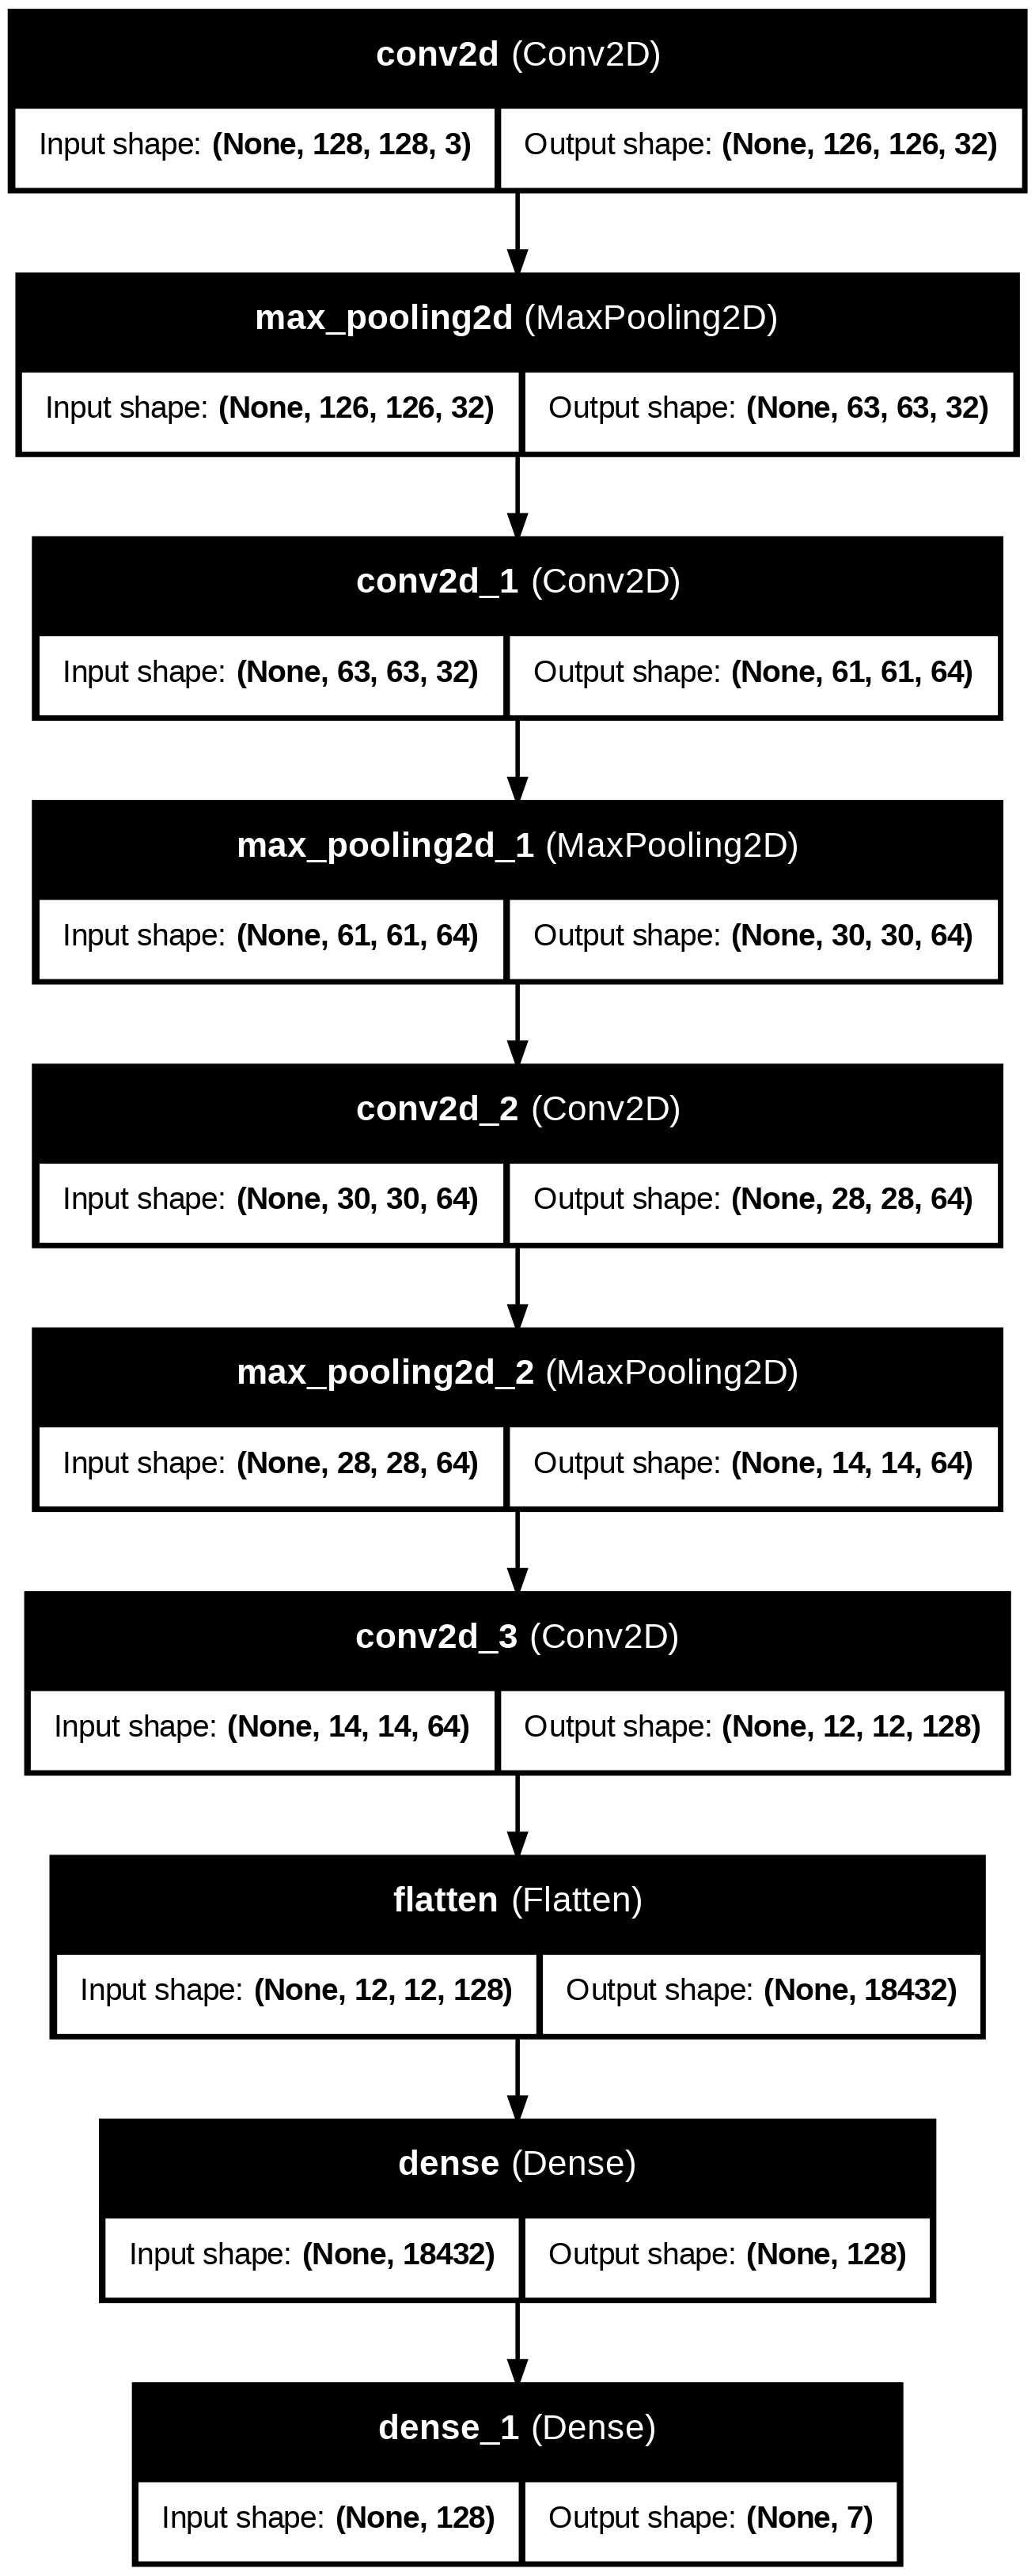

In [12]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Train and evaluate model, show model accuracy over epochs

Epoch 1/4
138/138 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.2972 - loss: 1.7283 - val_accuracy: 0.6507 - val_loss: 0.9892
Epoch 2/4
138/138 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.6921 - loss: 0.8922 - val_accuracy: 0.7914 - val_loss: 0.6115
Epoch 3/4
138/138 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.7761 - loss: 0.6574 - val_accuracy: 0.8237 - val_loss: 0.5139
Epoch 4/4
138/138 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8167 - loss: 0.5166 - val_accuracy: 0.8566 - val_loss: 0.4168


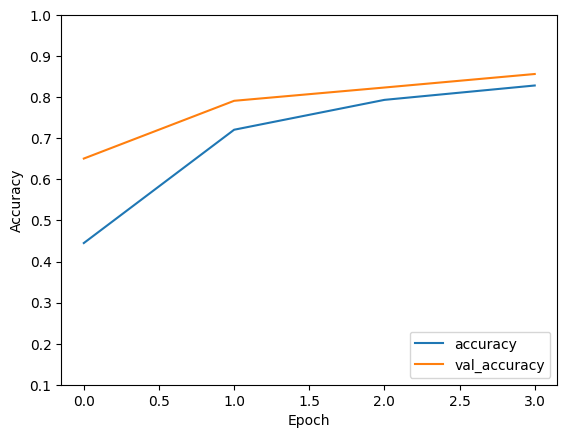

34/34 - 21s - 632ms/step - accuracy: 0.8382 - loss: 0.4495
0.8382353186607361


In [20]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=4,
          steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_dataset, steps=validation_steps, verbose = 2)
print(test_acc)

# Multilayer Perceptron (MLP)

In [23]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(128, 128, 3)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7))

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │       1,572,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,583,783 (6.04 MB)

 Trainable params: 1,583,783 (6.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.2322 - loss: 2.2335 - val_accuracy: 0.3915 - val_loss: 1.5355
Epoch 2/4
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3563 - loss: 1.6081 - val_accuracy: 0.3980 - val_loss: 1.5221
Epoch 3/4
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.4000 - loss: 1.5020 - val_accuracy: 0.3909 - val_loss: 1.5029
Epoch 4/4
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4170 - loss: 1.4658 - val_accuracy: 0.4200 - val_loss: 1.4396


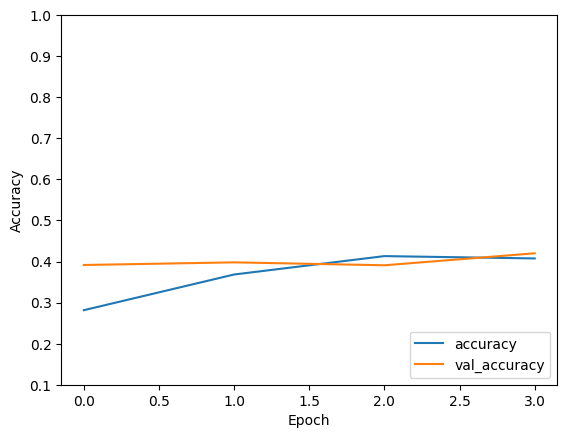

34/34 - 14s - 402ms/step - accuracy: 0.4099 - loss: 1.4636
0.40992647409439087


In [24]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=4,
          steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_dataset, steps=validation_steps, verbose = 2)
print(test_acc)